In [5]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
root_dir = os.path.dirname(os.getcwd())

In [135]:

def get_result(metric, dataid = 1, num_shot = 1, model = 'gill', misleading = 0):
    results_dir = os.path.join(root_dir, 'results')
    misleading_flag = '_m' if misleading else ''
    if metric[0] in ['llava', 'gpt']:
        results_dir = os.path.join(results_dir, f'{metric[0]}_evaluation{misleading_flag}')
    else:
        raise ValueError('Invalid metric')
    
    # find all the files in the directory
    files = os.listdir(results_dir)
    for file in files:
        if f'[{dataid}]' in file and f'{model}_{num_shot}shot' in file and not '(' in file:
            file_path = os.path.join(results_dir, file)
            with open(file_path, 'r') as f:
                results = json.load(f)[0]
                return results[metric[1]]
    return None

In [7]:
def get_image(
    model, 
    num_shot, 
    latent, 
    image_name, 
    dataid, 
    metric,
    task_category,
    task_subcategory,
):
    value_folder = f"{root_dir}/results/{metric}_evaluation/detail"
    image_folder = f"{root_dir}/results/{model}_results/shot_{num_shot}/{task_category}/{task_subcategory}"
    
    # get value file
    value_files = os.listdir(value_folder)
    score = None
    for file in value_files:
        file_condition1 = f'{dataid}' in file
        file_condition2 = f'{model}_{num_shot}shot_{latent}' in file
        if file_condition1 and file_condition2:
            value_file = os.path.join(value_folder, file)
            with open(value_file, 'r') as file:
                values = json.load(file)
                
            for value in values:
                if value['name'] == image_name:
                    score = value['score']
        
    # get image file
    image = None
    image_file = f"{image_folder}/{image_name}"
    image = plt.imread(image_file)
        
    return {'image': image, 'score': score}

In [1]:
def collect_images(
    model, 
    num_shot, 
    latent, 
    query, 
    dataid, 
    metric,
    task_category,
    task_subcategory, 
):
    image_folder = f"{root_dir}/results/{model}_results/shot_{num_shot}/{task_category}/{task_subcategory}"
   
    all_images = os.listdir(image_folder)
    results = []
    for image_name in all_images:
        if image_name.endswith(f'{query}_result.jpg'):
            results.append(get_image(
                model, 
                num_shot, 
                latent, 
                image_name, 
                dataid, 
                metric,
                task_category,
                task_subcategory,
            ))

    results = sorted(results, key = lambda x: x['score'])
    return results

In [2]:
def generate_zigzag_indices(n_rows, n_cols):
    if n_rows != n_cols:
        raise ValueError('n_rows and n_cols must be equal')
    
    indices = []
    for i in range(n_rows):
        for j in range(i):
            indices.append((j,i))
            indices.append((i,j))
        indices.append((i,i))

    return indices

In [3]:
def visualize(
    model, 
    num_shot, 
    latent, 
    query, 
    dataid, 
    metric,
    task_category,
    task_subcategory, 
    n_cols = 4,
    n_rows = 4,
):
    # Assuming each image is a numpy array of shape (height, width, channels)
    dummy_images = [None for _ in range(n_rows * n_cols)]
    random_images = [np.random.rand(100, 100, 3) for _ in range(n_rows * n_cols)]
    np.random.seed(0)

    results = collect_images(
        model,
        num_shot, 
        latent, 
        query, 
        dataid, 
        metric,
        task_category,
        task_subcategory,
    )

    # randomly pick images from the results
    np.random.seed(123)
    results = np.random.choice(results, size = min(n_rows * n_cols, len(results)), replace = False)
    results = sorted(results, key = lambda x: x['score'])

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace = 0.1) #margin of the figure
    indices = generate_zigzag_indices(n_rows, n_cols)

    if metric == 'llava':
        metric_annotation = 'LLaVA Accuracy'
    elif metric == 'clip':
        metric_annotation = 'CLIP Similarity'
    else:
        raise ValueError('Invalid metric')

    for index, (i, j) in enumerate(indices):
        ax = axes[i, j]
        if index < len(dummy_images):
            if index < len(results):
                ax.imshow(results[index]['image'])
                # Score annotation, replace with actual score if available
                score = results[index]['score']
                ax.annotate(f'{metric_annotation}: {score:.2f}', (0.5, 1), xycoords='axes fraction', textcoords='offset points', va='bottom', ha='center', fontsize = 13)
            else:
                ax.imshow(random_images[index])
            ax.axis('off')  # Hide axis for images
        else:
            ax.axis('off')  # Hide axis for empty subplots

    plt.tight_layout(pad=0.1)
    plt.savefig(f'{root_dir}/figures/{model}_{metric}_{latent}_{query}_{num_shot}.pdf')
    plt.show()

In [8]:
visualize(
    model = 'seed', 
    num_shot = 1, 
    latent = 'flower', 
    query = 'green', 
    dataid = 1, 
    metric = 'llava',
    task_category = 'color_object',
    task_subcategory = 'color_flower', 
    n_cols = 4,
    n_rows = 4,
)

FileNotFoundError: [Errno 2] No such file or directory: '/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/micl/results/seed_results/shot_1/color_object/color_flower'

/tmp/ipykernel_2633424/914386301.py:53: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(f'{metric_annotation}: {score:.2f}', (0.5, 1), xycoords='axes fraction', textcoords='offset points', va='bottom', ha='center', fontsize = 13)


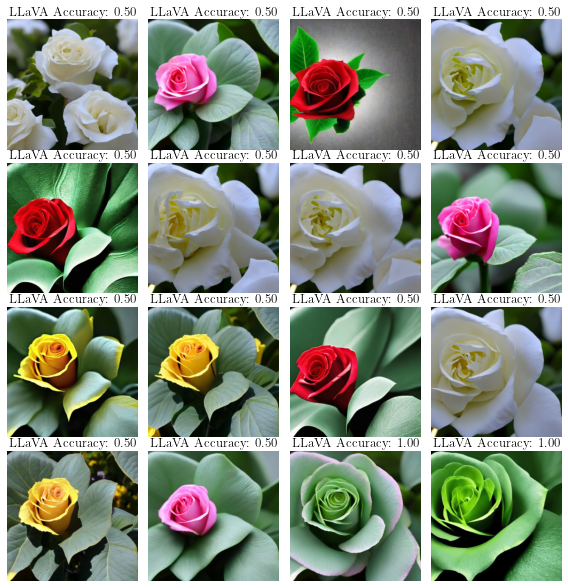

In [12]:
visualize(
    model = 'seed', 
    num_shot = 2, 
    latent = 'flower', 
    query = 'green', 
    dataid = 1, 
    metric = 'llava',
    task_category = 'color_object',
    task_subcategory = 'color_flower', 
    n_cols = 4,
    n_rows = 4,
)

/tmp/ipykernel_2633424/914386301.py:53: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(f'{metric_annotation}: {score:.2f}', (0.5, 1), xycoords='axes fraction', textcoords='offset points', va='bottom', ha='center', fontsize = 13)


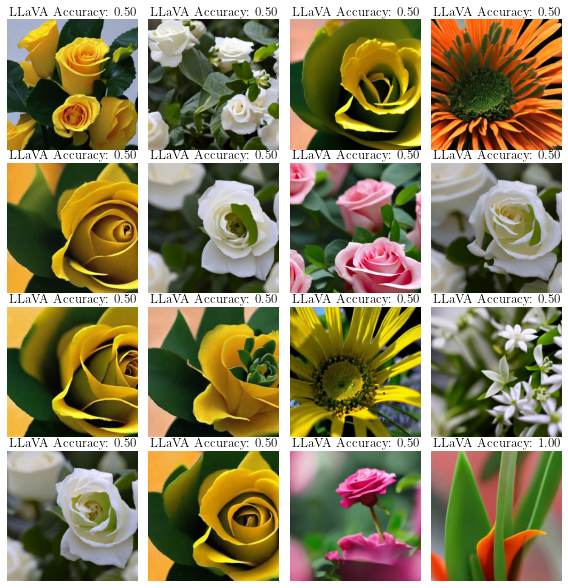

In [13]:
visualize(
    model = 'seed', 
    num_shot = 4, 
    latent = 'flower', 
    query = 'green', 
    dataid = 1, 
    metric = 'llava',
    task_category = 'color_object',
    task_subcategory = 'color_flower', 
    n_cols = 4,
    n_rows = 4,
)

In [17]:
vec_clip, vec_llava = [], []
for dataid in np.arange(1, 11):
    for shot in [1,2,4]:
        for mllm in ['gill', 'emu', 'seed']:
            for misleading in [0,1]:
                clip_result = get_result('clip', dataid, shot, mllm, misleading)
                llava_result = get_result('llava', dataid, shot, mllm, misleading)
                if clip_result and llava_result: 
                    vec_clip.append(clip_result)
                    vec_llava.append(llava_result)

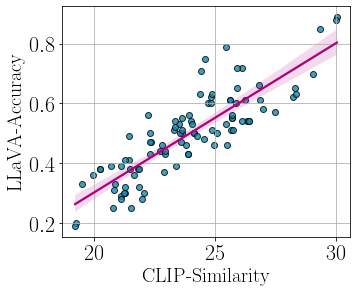

In [33]:
# Plot with a regression line and confidence interval
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 2.5
markers = ['s', 'o']
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
models = ['Emu', 'SEED-LLaMA', 'GILL']
lts = ['--', '-']
marker_sizes = [6, 5]
shots = [1,2,4]

fig, ax = plt.subplots(nrows = 1, ncols = 1, sharey = True)
fig.subplots_adjust(left=0.18, bottom=.18, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(5, 4) #exact size of the figure
sns.regplot(x=vec_clip, y=vec_llava, ci=95, color=colors[0], line_kws={'color': colors[5]}, scatter_kws={'color': colors[3], 'edgecolor': 'k'})

# plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
plt.xlabel('CLIP-Similarity', fontsize = 20)
plt.ylabel('LLaVA-Accuracy', fontsize = 20)
plt.grid(True)
fig.savefig(f'{root_dir}/figures/clip_llava.pdf')
plt.show()

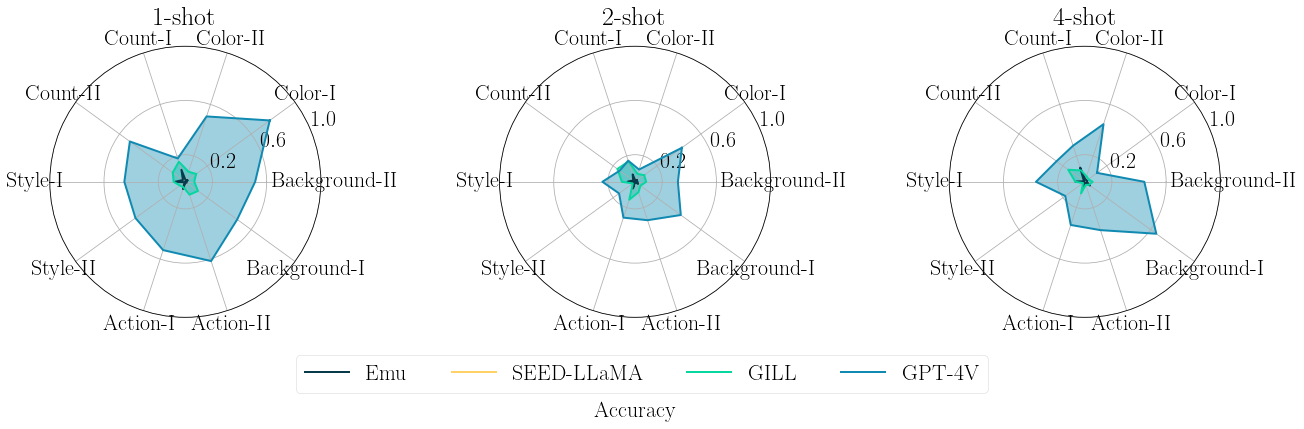

In [146]:
metric = ['gpt', 'textual']

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 2.5
markers = ['s', 'o']
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
models = ['Emu', 'SEED-LLaMA', 'GILL', 'GPT-4V']
lts = ['--', '-']
marker_sizes = [6, 5]
shots = [1,2,4]

# fig, ax = plt.subplots(nrows = 3, ncols = 1, sharey = True)
# fig.subplots_adjust(left=0.08, bottom=.1, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
# fig.set_size_inches(10, 6) #exact size of the figure

# Plotting bar plots for each cluster
clusters = [
    'Color-I', 'Color-II', 
    'Count-I', 'Count-II',
    'Style-I', 'Style-II',
    'Action-I', 'Action-II',
    'Background-I', 'Background-II',
]
bar_width = 0.2  # Width of each bar

model_str = {
    'Emu': 'Emu',
    'SEED-LLaMA': 'SEED',
    'GILL': 'gill',
    'GPT-4V': 'openai',
}

num_vars = len(clusters)

# Compute angle for each axis
angles = [(n+1) / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

# Radar plot setup
fig, axs = plt.subplots(nrows=1, ncols=3, subplot_kw=dict(polar=True))
fig.subplots_adjust(left=-.1, bottom=.5, right=1.15, top=0.95, wspace=-.25, hspace = 0) #margin of the figure
fig.set_size_inches(18, 6)

for row, num_shot in enumerate(shots):
    ax = axs[row]

    # Add one to the end to ensure the radar plot closes
    for j, model in enumerate(models):
        values = [get_result(metric, i+1, num_shot, model_str[model]) or 0 for i in range(num_vars)]
        values += values[:1]
        ax.plot(angles, values, color=colors[j % len(colors)], linewidth=2, linestyle='solid', label=models[j])
        ax.fill(angles, values, color=colors[j % len(colors)], alpha=0.4)
    
    ax.set_xticks(angles[:-1])
    ax.set_yticks([.2, .6, 1])
    ax.set_xticklabels(clusters, fontsize=22, rotation = 45)
    ax.set_title(f'{num_shot}-shot', fontsize=26, position=(0.5, 2), horizontalalignment='center', verticalalignment='top')

    if row == 0:
        ax.legend(bbox_to_anchor=(3.5, -.1), ncol=4, fontsize=22)

fig.supxlabel(f'Accuracy', fontsize=22)
plt.tight_layout()
fig.savefig(f'{root_dir}/figures/basic_{metric[0]}_radar_{metric[1]}.pdf')
plt.show()


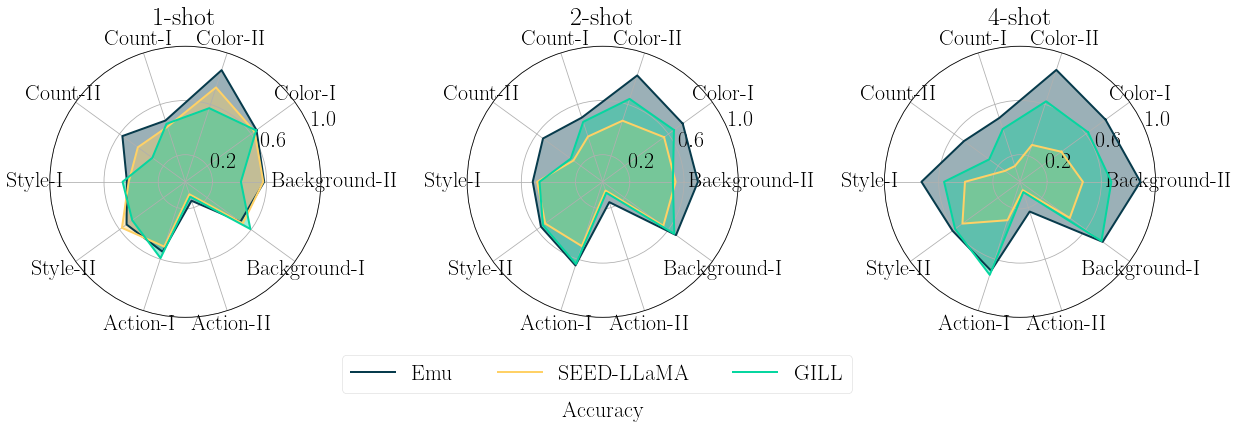

In [139]:
metric = ['llava', 'visual']

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 2.5
markers = ['s', 'o']
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
models = ['Emu', 'SEED-LLaMA', 'GILL']
lts = ['--', '-']
marker_sizes = [6, 5]
shots = [1,2,4]

# fig, ax = plt.subplots(nrows = 3, ncols = 1, sharey = True)
# fig.subplots_adjust(left=0.08, bottom=.1, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
# fig.set_size_inches(10, 6) #exact size of the figure

# Plotting bar plots for each cluster
clusters = [
    'Color-I', 'Color-II', 
    'Count-I', 'Count-II',
    'Style-I', 'Style-II',
    'Action-I', 'Action-II',
    'Background-I', 'Background-II',
]
bar_width = 0.2  # Width of each bar

model_str = {
    'Emu': 'Emu',
    'SEED-LLaMA': 'SEED',
    'GILL': 'gill'
}

num_vars = len(clusters)

# Compute angle for each axis
angles = [(n+1) / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

# Radar plot setup
fig, axs = plt.subplots(nrows=1, ncols=3, subplot_kw=dict(polar=True))
fig.subplots_adjust(left=-.1, bottom=.5, right=1.15, top=0.95, wspace=-.25, hspace = 0) #margin of the figure
fig.set_size_inches(18, 6)

for row, num_shot in enumerate(shots):
    ax = axs[row]

    # Add one to the end to ensure the radar plot closes
    for j, model in enumerate(models):
        values = [get_result(metric, i+1, num_shot, model_str[model]) or 0 for i in range(num_vars)]
        values += values[:1]
        ax.plot(angles, values, color=colors[j % len(colors)], linewidth=2, linestyle='solid', label=models[j])
        ax.fill(angles, values, color=colors[j % len(colors)], alpha=0.4)
    
    ax.set_xticks(angles[:-1])
    ax.set_yticks([.2, .6, 1])
    ax.set_xticklabels(clusters, fontsize=22, rotation = 45)
    ax.set_title(f'{num_shot}-shot', fontsize=26, position=(0.5, 2), horizontalalignment='center', verticalalignment='top')

    if row == 0:
        ax.legend(bbox_to_anchor=(3, -.1), ncol=3, fontsize=22)

fig.supxlabel(f'Accuracy', fontsize=22)
plt.tight_layout()
fig.savefig(f'{root_dir}/figures/basic_{metric[0]}_radar_{metric[1]}.pdf')
plt.show()
